## Imports

In [ ]:
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sys
from sklearn.metrics import make_scorer
from sklearn.metrics import log_loss
import lightgbm as lgb
sys.path.append('../utils/')
from Read_data import read_data
from evaluation import evaluation_class
import ourPreprocessor
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier

## Preparing the data

Loading data


In [6]:
# Loading data
pipelinetime = '18-05-27-13-14'
X_train, Y_train, X_test, Y_test, Y_train_cateogorial, Y_test_cateogorial = read_data(pipelinetime, stack = True, stage2=False)
print(X_train.shape, Y_test.shape, X_test.shape, Y_train.shape)
#Oversampling


(3683, 110) (125,) (125, 110) (3683,)


In [7]:
from imblearn.over_sampling import ADASYN
balance='auto'
X_resampled, y_resampled = ADASYN(ratio='auto').fit_sample(X_train,Y_train)
y_resampled=y_resampled-1


In [ ]:
modeltime = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
x1, x2, y1, y2 = train_test_split(X_resampled, y_resampled, test_size=0)
model = CatBoostClassifier(iterations = 250,
                      learning_rate=0.01,
                      depth=3,
                      l2_leaf_reg=1,
                      model_size_reg=10,
                      rsm=None,
                      loss_function='MultiClass',
                      random_seed=100, 
                      classes_count=9,
                      verbose = False,
                      bagging_temperature=1.0,
                      boosting_type='Plain', #Ordered — Usually provides better quality on small datasets, but it may be slower than the Plain scheme. Plain — The classic gradient boosting scheme.
                      max_bin=255)
model.fit(x1,y1)
preds = model.predict_proba(X_test)
        
if preds.shape[0] == 986:
# Any results you write to the current directory are saved as output.
    stage1_test = pd.read_csv('/mnt/4_TB_HD/ramona/utils/data/test_variants')
    stage2_test = pd.read_csv('/mnt/4_TB_HD/ramona/utils/stage2_data/stage2_test_variants.csv')
    stage1_solution = pd.read_csv('/mnt/4_TB_HD/ramona/utils/data/solution_filtered.csv')
    stage1_solution = stage1_solution.merge(stage1_test, how = 'left', on = 'ID')
    stage2_test= stage2_test.merge( stage1_solution.drop('ID', axis = 1), how = 'left',  on = ['Gene', 'Variation'])\
                                                                .drop(['Gene', 'Variation'], axis = 1)\
                                                                .fillna(value = submission )
if preds.shape[0] == 986:
    Y_test_stage2_id = pd.read_pickle('../utils/stage2_data/stage2test_classes.sav')['ID'].values
    preds = np.take(preds,(list(Y_test_stage2_id-1)), axis =0) 
weighting = None
balance = 'auto'
ev = evaluation_class(1000,y_pred=preds, Y_test=Y_test, pipelinedate = pipelinetime, modeltime =modeltime, weighting = weighting, balance = balance)
accuracy, logloss, f1_micro, f1_macro = ev.evaluation_values()
  

In [25]:
submission = pd.DataFrame(old_pred, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = np.arange(1,(old_pred.shape[0]+1))

Accuracy: 0.504 Log loss: 1.6922410275348936 F1 micro: 0.504 F1 macro: 0.42623704815429214


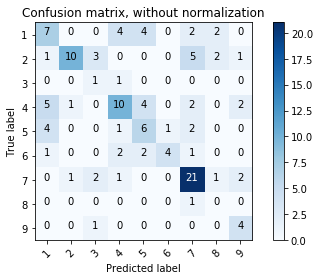

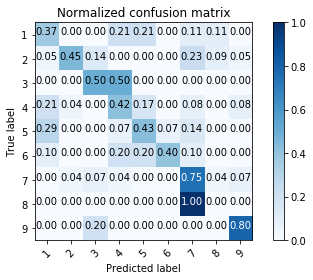

one row with the evaluation data is appended at /mnt/4_TB_HD/ramona/develop/results_catboost.csv


In [27]:
ev = evaluation_class(1000,y_pred=old_pred, Y_test=Y_test, pipelinedate = pipelinetime, modeltime =modeltime, weighting = weighting, balance = balance)
ev.entire_evaluation(filename = '/mnt/4_TB_HD/ramona/develop/results_catboost.csv', filename_trainingmodel='models/catboost_'+'modeltime_'+modeltime+'pipelinetime_'+pipelinetime)
#stage2_test.to_csv(str('submissions/submission_catboost_with_leak_' + pipelinetime+'_'+ modeltime +'.csv'), index = False)
submission.to_csv('submissions/submission_catboost_'+pipelinetime +'_'+ modeltime+'.csv', index=False)
old_model.save_model('models/catboost_'+'modeltime_'+modeltime+'pipelinetime_'+pipelinetime)

#### Leak 

In [ ]:
#submission_to_fill = pd.read_csv('submission_lightGBM_18-05-14-11-00.csv')
submission_filled = pd.read_csv('submissions/submission_catboost_'+pipelinetime+'_'+ modeltime+'.csv')

if submission_filled.shape[0] > 200:
# Any results you write to the current directory are saved as output.
    submission = pd.read_csv('/mnt/4_TB_HD/ramona/utils/stage2_data/stage2_sample_submission.csv')
    stage1_test = pd.read_csv('/mnt/4_TB_HD/ramona/utils/data/test_variants')
    stage2_test = pd.read_csv('/mnt/4_TB_HD/ramona/utils/stage2_data/stage2_test_variants.csv')
    stage1_solution = pd.read_csv('/mnt/4_TB_HD/ramona/utils/data/solution_filtered.csv')

    stage1_solution = stage1_solution.merge(stage1_test, how = 'left', on = 'ID')

    stage2_test.merge( stage1_solution.drop('ID', axis = 1), how = 'left',  on = ['Gene', 'Variation'])\
        .drop(['Gene', 'Variation'], axis = 1)\
        .fillna(value = submission_filled )\
        .to_csv(str('submissions/submission_catboost_with_leak_' + pipelinetime+'_'+ modeltime +'.csv'), index = False)
